In [20]:
from astropy.table import Table

fig_dir = '../../figures/samples/'
source_dir = '../../fits/'
save_dir = '../../fits/'

fs = 10

from astroML import plotting
from scipy.stats import ks_2samp

#-------------------------
import matplotlib as mpl
from prefig import Prefig
Prefig()
% matplotlib inline

from matplotlib.ticker import MaxNLocator

plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'
#-------------------------

clr = ['orange','red','magenta','green','blue']
titles = ['1','2','3','4','5+','??']

In [14]:
sample = fits.getdata(source_dir + 'BD_volume_limited_sample.fits',1)
debiased = fits.getdata(source_dir + 'BD_debiased.fits',1)

sample = Table(sample)
debiased = Table(debiased)

In [28]:
p_spiral = (sample.field("t01_smooth_or_features_a02_features_or_disk_debiased")
        *sample.field("t02_edgeon_a05_no_debiased")
        *sample.field("t04_spiral_a08_spiral_debiased"))
N_spiral = (sample.field("t04_spiral_a08_spiral_count")) # Load values to
    # allow data cuts to be made.
    
select_spiral = (p_spiral > 0.5) & (N_spiral >= 5) & (np.isfinite(sample['logMt']))

spirals = sample[select_spiral]
debiased_spirals = debiased[select_spiral]

select_mass = spirals['LOGMSTAR_BALDRY06'] >= 10.6

In [16]:
def assign(table,debiased_table,th=0,redistribute=False,rd_th=0,ct_th=0,print_sizes=False,raw=False):
    
    m_columns = debiased_table.colnames
    
    if raw == True:
        m_array = np.array([table[column] for column in m_columns]).T
    else:
        m_array = np.array([debiased_table[column] for column in m_columns]).T
    
    arm_assignments = np.ones(len(table))*(-999) # Assigned arm numbers 
    # initially is an array of -999s. -999 means 'no assignment'.
    for m in range(6):
        a = (np.argmax(m_array,axis=1) == m) & (m_array[:,m] >= th)
        arm_assignments[a] = m
        
    if redistribute is True: # Redistribute according to thresholds.
        for m in range(5):
            arm_assignments[(np.argmax(m_array[:,:5],axis=1) == m) 
                & (arm_assignments == 5) & (table[:,m]/table[:,5] > rd_th) 
                & (table[:,5] <= ct_th)] = m

    if print_sizes is True:
        print("total sample: " + str(len(arm_assignments)))
        print("total 'assigned' sample: " 
              + str(np.sum(arm_assignments != -999)))
        for m in range(6):
            print("m = " + str(m+1) + ": " 
                  + str(np.sum(arm_assignments == m)))
      
    return arm_assignments

In [48]:
def histogram(bins,data,spirals,x,arm_assignments,y=None,
              mean_line=False,sigma_lines=False,ks=False,full_distribution='spirals'):
    
    # 'bins' takes the values (as from astroML.plotting.hist eg 'blocks').
    # Changing the 'full_distribution' value changes the underplotted 
    # values from only spiral galaxies to all galaxies.
    
    # x = column to 'histogram'

    for m in range(5):
        
        if full_distribution == 'spirals':
            full = spirals
        else:
            full = data
    
        m_gals = spirals[arm_assignments == m]
        
        if y is not None:
            col_full = full[x] - full[y]
            col_plot = m_gals[x] - m_gals[y]
        else:
            col_full = full[x]
            col_plot = m_gals[x]
        
        plotting.hist(col_full,bins=bins,normed=True,ax=axes[m]
                      ,histtype='stepfilled',color='k',alpha=0.4)
        
        plotting.hist(col_plot,bins=bins,normed=True,ax=axes[m]
                      ,histtype='step',color=clr[m],linewidth=2)
        
        ylims = axes[m].get_ylim()
        
    for m in range(5):
        m_gals = spirals[arm_assignments == m]
    
        if mean_line is True:
            mean = np.mean(m_gals[x])
            axes[m].vlines(mean,ylims[0],ylims[1],color=clr[m],linewidth=2,linestyle='dashed')
        if sigma_lines is True:
            sigma = np.std(m_gals[x])
            for line_value in [mean-sigma,mean+sigma]:
                axes[m].vlines(line_value,ylims[0],ylims[1],color=clr[m],linewidth=2,linestyle='dotted')
                
        if ks is True:
            ks_values = ks_2samp(full[x],m_gals[x])
            #print(ks_values[1])
            print('KS test values for m={}'.format(m+1) + 
                  ':{0:.4f}'.format(ks_values[1]))
            
    axes[m].yaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    axes[m].xaxis.set_major_locator(MaxNLocator(nbins=5,prune='both'))
    
    return None

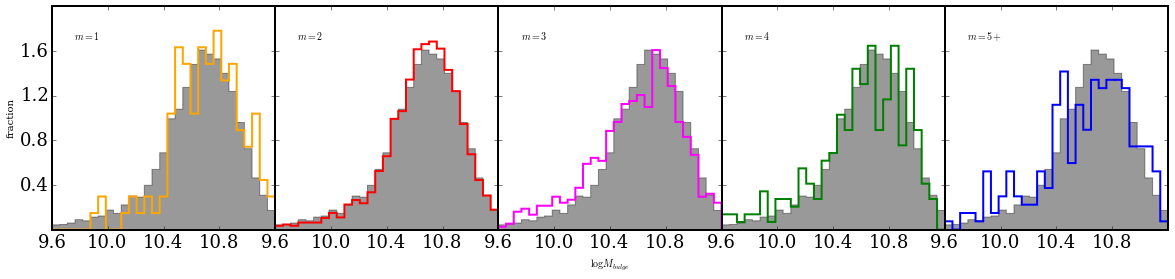

In [35]:
# Bulge masses

mass_lim = True

if mass_lim == True:
    s = spirals[select_mass]
    d = debiased_spirals[select_mass]
else:
    s = spirals
    d = debiased_spirals
#-------------------------------------
    
a = assign(s,d)
    
xlims = [9.6,11.2]
ylims = [0,2]
xt = [9.5,11.5,0.5]
yt = [0.5,2,0.5]
            
fig,axes = plt.subplots(1,5,figsize=(20,4),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)

axes[0].set_ylabel('fraction',fontsize=fs)
axes[2].set_xlabel('$\log M_{bulge}$',fontsize=fs)
axes[0].set_xlim(xlims)
axes[0].set_ylim(ylims)

for m in range(5):
    axes[m].text(0.1,0.9,r"$m={}$".format(titles[m]),family="serif"
                  ,horizontalalignment='left',verticalalignment='top'
                  ,transform = axes[m].transAxes,fontsize=fs)

bins = np.linspace(xlims[0],xlims[1],30)

histogram(bins,sample,s,'logMb',a)
    
#plt.savefig('../../BD_images/histograms/bulges_histogram.pdf')

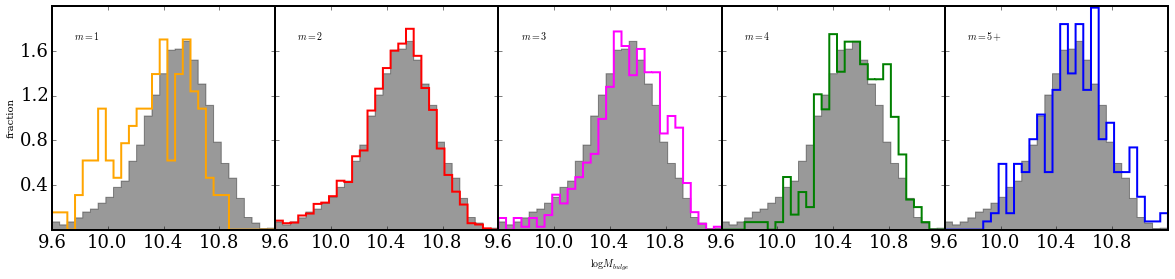

In [36]:
# Disk masses

mass_lim = True

if mass_lim == True:
    s = spirals[select_mass]
    d = debiased_spirals[select_mass]
else:
    s = spirals
    d = debiased_spirals
#-------------------------------------
    
a = assign(s,d)
    
xlims = [9.6,11.2]
ylims = [0,2]
xt = [9.5,11.5,0.5]
yt = [0.5,2,0.5]
            
fig,axes = plt.subplots(1,5,figsize=(20,4),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)

axes[0].set_ylabel('fraction',fontsize=fs)
axes[2].set_xlabel('$\log M_{bulge}$',fontsize=fs)
axes[0].set_xlim(xlims)
axes[0].set_ylim(ylims)

for m in range(5):
    axes[m].text(0.1,0.9,r"$m={}$".format(titles[m]),family="serif"
                  ,horizontalalignment='left',verticalalignment='top'
                  ,transform = axes[m].transAxes,fontsize=fs)

bins = np.linspace(xlims[0],xlims[1],30)

histogram(bins,sample,s,'logMd',a)
    
#plt.savefig('../../BD_images/histograms/bulges_histogram.pdf')

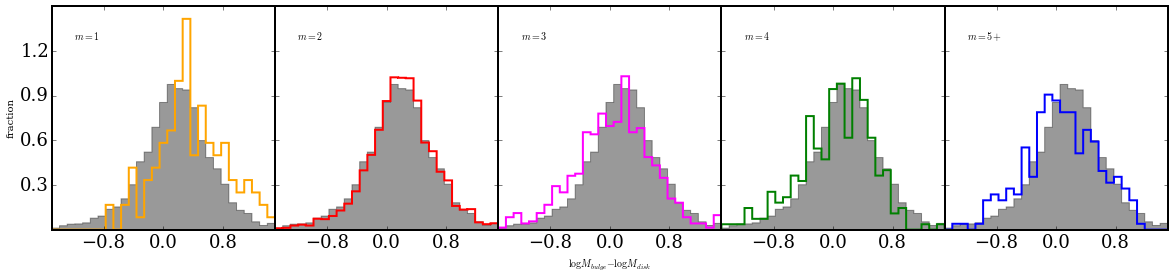

In [55]:
# Disk fractions?

mass_lim = True

if mass_lim == True:
    s = spirals[select_mass]
    d = debiased_spirals[select_mass]
else:
    s = spirals
    d = debiased_spirals
#-------------------------------------
    
a = assign(s,d)
    
xlims = [-1.5,1.5]
ylims = [0,1.5]
xt = []
yt = [0.5,2,0.5]
            
fig,axes = plt.subplots(1,5,figsize=(20,4),sharex=True,sharey=True)
fig.subplots_adjust(hspace=0,wspace=0)

axes[0].set_ylabel('fraction',fontsize=fs)
axes[2].set_xlabel('$\log M_{bulge} - \log M_{disk}$',fontsize=fs)
axes[0].set_xlim(xlims)
axes[0].set_ylim(ylims)

for m in range(5):
    axes[m].text(0.1,0.9,r"$m={}$".format(titles[m]),family="serif"
                  ,horizontalalignment='left',verticalalignment='top'
                  ,transform = axes[m].transAxes,fontsize=fs)

bins = np.linspace(xlims[0],xlims[1],30)

histogram(bins,sample,s,'logMb',a,y='logMd')
    
#plt.savefig('../../BD_images/histograms/bulges_histogram.pdf')

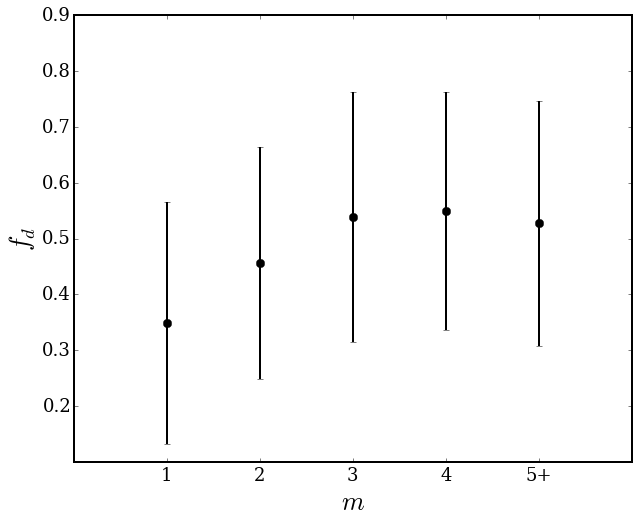

In [66]:
# Disk fraction plots?

mass_lim = True

if mass_lim == True:
    s = spirals[select_mass]
    d = debiased_spirals[select_mass]
else:
    s = spirals
    d = debiased_spirals
#-------------------------------------
    
a = assign(s,d)

fig,ax = plt.subplots()

means = np.zeros((5,3))

means[:,0]=np.arange(5) + 1

fractions = 10**(s['logMd']-s['logMt'])

means[:,1] = [np.mean(fractions[a == m]) for m in range(5)]
means[:,2] = [np.std(fractions[a == m]) for m in range(5)]

plt.errorbar(means[:,0],means[:,1],yerr=means[:,2],fmt='ko')

plt.xlim(0,6)
plt.xticks([1,2,3,4,5])
plt.ylim(0.1,0.9)
#plt.yticks(np.arange(0.5,0.79,0.1))

#labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['1','2','3','4','5+']
ax.set_xticklabels(labels)

plt.xlabel('$m$')
plt.ylabel('$f_d$')